## Importation of packages, settings of the GPU, definitions of global constants

In [ ]:
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as Trf

In [ ]:
# Reproducibility
torch.manual_seed(0)

use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
batch_size = 128
learning_rate = 1e-4

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Architecture

In [ ]:
class FC_Block(nn.Module):
    """
    Fully connected block
    """
    def __init__(self,in_features, out_features):
        super(FC_Block, self).__init__()
        self.lin = nn.Linear(in_features=in_features, out_features=out_features)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        x = self.bn(F.relu(self.lin(x)))

        return x

class Attention(nn.Module):
    
    def __init__(self, x_size, hidden_size, value=False):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.value = value

        self.WQ = nn.Parameter(torch.randn((x_size, hidden_size), requires_grad=True))
        self.WK = nn.Parameter(torch.randn((x_size, hidden_size), requires_grad=True))
        if self.value :
            self.WV = nn.Parameter(torch.randn((x_size, hidden_size), requires_grad=True))

        self.softmax = torch.nn.Softmax(dim=2)
        
    def forward(self, X, h):
        """
        X is the matrix composed of the different output of each brick.
        h is the output of a brick so h is of size = ( batch_size, n_hidden)
        h is present in X as one of its line.
        """
        # We have to unsqueeze h because otherwise we do
        # batch vector * batch matrix
        # and we mix the batches together
        # because, batch vector is interpreted as a matrix independant of batches
        h = torch.unsqueeze(h, 1)

        # Now we have a batch matrix and another batch matrix.
        # Pytorch knows that he has to work dimension by dimension
        Q = torch.matmul(h, self.WQ)
        V = 0
        if self.value:
            V = torch.matmul(X, self.WV)
        else:
            V = X
        K = torch.matmul(X, self.WK)

        dot = torch.matmul(Q, torch.transpose(K, 1, 2))
        dot /= torch.sqrt(torch.tensor(self.hidden_size, dtype=torch.float64))
        softmax = self.softmax(dot)
        return torch.matmul(softmax, V)

class MNN(nn.Module):
    def __init__(self, name, n_layers, n_bricks, params_block, hidden_size = 8, att_tran = True, att_top_down = True):
        super(MNN, self).__init__()

        # General parameters
        self.name = name
        self.n_layers = n_layers
        self.n_bricks = n_bricks
        self.params_block = params_block
        self.modulelist = nn.ModuleList()
        self.params = nn.ParameterList()
        self.hidden_size = hidden_size
        self.att_tran = att_tran
        self.att_top_down = att_top_down
        self.train_loss = []
        self.test_loss = []

        # Block parametres
        self.mat_blocks = [[0 for j in range(n_bricks)] for i in range(n_layers)]
        self.mat_x = [[0 for j in range(n_bricks)] for i in range(n_layers)]
        for i in range(n_layers):
            for j in range(n_bricks):
                self.mat_blocks[i][j] = FC_Block(params_block[i][j][0],
                                                params_block[i][j][1])
                self.modulelist.append(self.mat_blocks[i][j].lin)
                self.modulelist.append(self.mat_blocks[i][j].bn)
        # We assemble in the out layer the result of the bricks
        n_out = sum([self.params_block[-1][j][1] for j in range(self.n_bricks)])
        self.out = nn.Linear(in_features=n_out, out_features=10)
        self.modulelist.append(self.out)

        if self.att_tran:
        # Transversal attention
            self.mat_tran = [[0 for j in range(n_bricks)] for i in range(n_layers)]
            for i in range(n_layers-1):
                for j in range(n_bricks):
                    self.mat_tran[i][j] = Attention(params_block[i][j][1], self.hidden_size)
                    self.params.append(self.mat_tran[i][j].WQ)
                    self.params.append(self.mat_tran[i][j].WK)
                    # self.params.append(self.mat_tran[i][j].WV)

        if self.att_top_down:
        # Top-down attention
            self.mat_top_down = [[0 for j in range(n_bricks)] for i in range(n_layers)]
            for i in range(n_layers-1):
                for j in range(n_bricks):
                    self.mat_top_down[i][j] = Attention(params_block[i][j][1], self.hidden_size)
                    self.params.append(self.mat_top_down[i][j].WQ)
                    self.params.append(self.mat_top_down[i][j].WK)
                    # self.params.append(self.mat_top_down[i][j].WV)
            
    def forward(self, x):
        # flatten image input
        x = x.view(-1,28*28)
        
        # initialisation
        for j in range(self.n_bricks):
            # M
            self.mat_x[0][j] = self.mat_blocks[0][j](x)

        # propagation
        for i in range(1, self.n_layers):

            # We save the results of the attention (if there are some) in the matrix mat_x_after_att
            mat_x_after_att = [0 for i in range(len(self.mat_x[i-1]))]
            if self.att_tran or self.att_top_down:
                for k in range(len(mat_x_after_att)):
                    mat_x_after_att[k] = torch.zeros_like(self.mat_x[i-1][k])

            # Transversal Attention
            if self.att_tran:
                for j in range(self.n_bricks):
                    X = torch.cat(self.mat_x[i-1], dim=1) # size = (batch, 28*28*n_bricks)
                    X = X.view(X.size()[0], self.n_bricks, -1)  # size = (batch, n_bricks, 28*28)
                    h = X[:,j,:]
                    att = self.mat_tran[i-1][j](X,h)
                    mat_x_after_att[j] += torch.squeeze(att, dim = 1) # += or = ?

            # Top_Down Attention
            if self.att_top_down:
                for j in range(self.n_bricks):
                    # putting all previous self.mat_x[i_][j] at the same size as self.mat_x[i-1][j]
                    X = torch.cat([nn.functional.interpolate(torch.unsqueeze(self.mat_x[i_][j], 1),
                                                            size=self.mat_x[i-1][j].size()[1],
                                                            mode='nearest')
                                    for i_ in range(i)], dim=1)
                    X = X.view(X.size()[0], i, -1) # size = (batch, i : current layer, 28*28)
                    h = X[:,i-1,:] # the last line in X represents the block i - 1, j
                    att = self.mat_top_down[i-1][j](X,h)
                    mat_x_after_att[j] += torch.squeeze(att, dim = 1) # += or = ?

            # Apply the Attentions specified in the parameters
            if self.att_tran or self.att_top_down:
                self.mat_x[i-1] = mat_x_after_att

            # Propagation with feedforward
            for j in range(self.n_bricks):
                self.mat_x[i][j] = self.mat_blocks[i][j](self.mat_x[i-1][j])
        # out
        x_out = torch.cat(self.mat_x[-1], dim=1)
        return self.out(x_out)



In [ ]:
def number_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def create_net(name, n_layers, n_bricks, params_block, hidden_size,
               att_tran, att_top_down):
    """
    create the net and print the number of parameters in the FFN, and in the attention
    """
    model = MNN(name=name, n_layers=n_layers, n_bricks=n_bricks, params_block=params_block,
                hidden_size=hidden_size,
                att_tran=att_tran, att_top_down=att_top_down)
    model = model.to(device) # le mettre apreès mais pas ici

    nb_params = number_params(model)

    nb_params_tran = 0
    if att_tran:
        model_without_tran = MNN(name=name, n_layers=n_layers, n_bricks=n_bricks,
                               params_block=params_block, att_tran=False,
                               att_top_down=att_top_down)
        nb_params_without_tran = number_params(model_without_tran)
        nb_params_tran = nb_params - nb_params_without_tran
        del model_without_tran

    nb_params_td = 0
    if att_top_down:
        model_without_td = MNN(name=name, n_layers=n_layers, n_bricks=n_bricks,
                               params_block=params_block, att_tran=att_tran,
                               att_top_down=False)  
        nb_params_without_td = number_params(model_without_td)
        nb_params_td = nb_params - nb_params_without_td
        del model_without_td

    print("Model name:", name)
    print("Nb params in total:", nb_params)
    print("Nb params in transversal attention:", nb_params_tran)
    print("Nb params in top-down attention:", nb_params_td)
    print('')

    return model

## Training

In [ ]:
def train(model, nb_epoch=None, verbose=True):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # set to training mode
    model.train()

    train_loss_avg = []
    test_loss_avg = []

    if verbose : print('Training ...')
    NEPOCH = nb_epoch if nb_epoch else num_epoch 
    for epoch in range(NEPOCH):
        train_loss_avg.append(0)
        num_batches_train = 0

        test_loss_avg.append(0)
        num_batches_test = 0
        
        for image_batch, labels in train_dataloader:
            
            image_batch = image_batch.to(device)
            labels = labels.to(device)

            outputs = model(image_batch)
            
            # classification error
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, labels)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            train_loss_avg[-1] += loss.item()
            num_batches_train += 1

        with torch.no_grad():
            for image_batch, labels in test_dataloader:
            
                image_batch = image_batch.to(device)
                labels = labels.to(device)

                outputs = model(image_batch)

                criterion = nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)

                test_loss_avg[-1] += loss.item()
                num_batches_test += 1
            
        train_loss_avg[-1] /= num_batches_train
        test_loss_avg[-1] /= num_batches_test
        model.train_loss.append(train_loss_avg[-1])
        model.test_loss.append(test_loss_avg[-1])
        if verbose : print('Epoch [%d / %d]. Train loss: %f. Test loss: %f.' % (epoch+1, NEPOCH, train_loss_avg[-1], test_loss_avg[-1]))

def plot_losses(model):
    # Plot training curve
    plt.ion()
    fig = plt.figure()
    plt.plot(model.train_loss, label="train")
    plt.plot(model.test_loss, label="test")
    plt.legend()
    plt.title(model.name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

## Test of different models

In [ ]:
"""
The bricks have to be equal to each other in order to do the transversal attention
"""
params_block_1b4l = [  # brick 0        
                [(28*28, 256)],   # first layer
                [(256  , 256)],
                [(256  , 256)],
                [(256, 10   )]    
                ]

params_block_3b4l = [# brick 0           brick 1         brick2
                [(28*28, 10*10), (28*28, 10*10), (28*28, 10*10)],   # first layer
                [(10*10, 10*10), (10*10, 10*10), (10*10, 10*10)],   # second layer
                [(10*10, 10*10), (10*10, 10*10), (10*10, 10*10)],   
                [(10*10, 10   ), (10*10, 10   ), (10*10, 10   )]    
                ]

params_block_1b12l = [# brick 0
                     [(28*28, 256)],   # first layer
                     [(256,   128)],   # second layer
                     [(128,   128)],
                     [(128,   128)], 
                     [(128,   128)], 
                     [(128,   128)], 
                     [(128,   128)], 
                     [(128,   128)],
                     [(128,   128)], 
                     [(128,   128)],   
                     [(128,    64)],
                     [(64,     10)],  
                     ]

params_block_2b6l = [# brick 0      # brick 1
                     [(28*28, 256), (28*28, 256)],   # first layer
                     [(256,   128), (256,   128)],   # second layer
                     [(128,   128), (128,   128)],
                     [(128,   128), (128,   128)],   
                     [(128,    64), (128,    64)],
                     [(64,     10), (64,     10)],  
                     ]

# Verifier qu'on ne peut pas faire autrement
params_block_12b2l = [# brick 0      # brick 1
                     [(28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256), (28*28, 256)],   # first layer
                     [(256,   10), (256,   10), (256,   10), (256,   10), (256,   10), (256,   10), (256,   10), (256,   10), (256,   10), (256,   10), (256,   10), (256,   10)],   # second layer
                     ]

ls_params_block = [params_block_1b4l, params_block_3b4l, params_block_1b12l, params_block_2b6l, params_block_12b2l]

# Name convention: (Number of bricks)b(Number of layers)l(Size of h)h(T if att_tran else t)(TD if att_top_down else td)

# Baseline without attention : perceptron
mnn_1b4lttd = create_net(name="perceptron1b4lttd", n_layers=4, n_bricks=1, params_block=params_block_1b4l, hidden_size = 20, att_tran=False, att_top_down=False)

# MAIN BASELINE
# Baseline with attention
mnn_3b4l = create_net(name="baseline3b4l", n_layers=4, n_bricks=3, params_block=params_block_3b4l, hidden_size = 20, att_tran=True, att_top_down=True)

# 1. Test different hidden_size
# Test with hidden size = 8
mnn_3b4l8h = create_net(name="3b4l8h", n_layers=4, n_bricks=3, params_block=params_block_3b4l, hidden_size = 8, att_tran=True, att_top_down=True)

# Test with hidden size = 40
mnn_3b4l40h = create_net(name="3b4l40h", n_layers=4, n_bricks=3, params_block=params_block_3b4l, hidden_size = 40, att_tran=True, att_top_down=True)

# 2. Test different type of attentions
# Test only att_top_down
mnn_3b4ltTD = create_net(name="3b4ltTD", n_layers=4, n_bricks=3, params_block=params_block_3b4l, hidden_size = 20, att_tran=False, att_top_down=True)

# Test only att_tran
mnn_3b4lTtd = create_net(name="3b4lTtd", n_layers=4, n_bricks=3, params_block=params_block_3b4l, hidden_size = 20, att_tran=True, att_top_down=False)

# Test without attention
mnn_3b4lttd = create_net(name="3b4lttd", n_layers=4, n_bricks=3, params_block=params_block_3b4l, hidden_size = 20, att_tran=False, att_top_down=False)

# 3. Test different architectures
# Test number of layers
mnn_1b12lTTD = create_net(name="1b12lTTD", n_layers=12, n_bricks=1, params_block=params_block_1b12l, hidden_size = 20, att_tran=True, att_top_down=True)
mnn_1b12lTtd = create_net(name="1b12lTtd", n_layers=12, n_bricks=1, params_block=params_block_1b12l, hidden_size = 20, att_tran=True, att_top_down=False)
mnn_1b12ltTD = create_net(name="1b12ltTD", n_layers=12, n_bricks=1, params_block=params_block_1b12l, hidden_size = 20, att_tran=False, att_top_down=True)
mnn_1b12lttd = create_net(name="1b12lttd", n_layers=12, n_bricks=1, params_block=params_block_1b12l, hidden_size = 20, att_tran=False, att_top_down=False)

# Test difference number of layers and bricks
mnn_2b6lTTD = create_net(name="2b6lTTD", n_layers=6, n_bricks=2, params_block=params_block_2b6l, hidden_size = 20, att_tran=True, att_top_down=True)
mnn_2b6lTtd = create_net(name="2b6lTtd", n_layers=6, n_bricks=2, params_block=params_block_2b6l, hidden_size = 20, att_tran=True, att_top_down=False)
mnn_2b6ltTD = create_net(name="2b6ltTD", n_layers=6, n_bricks=2, params_block=params_block_2b6l, hidden_size = 20, att_tran=False, att_top_down=True)
mnn_2b6lTTD = create_net(name="2b6lTTD", n_layers=6, n_bricks=2, params_block=params_block_2b6l, hidden_size = 20, att_tran=False, att_top_down=False)

# Inserer dans la liste les 8p resceedentes

# Test number of bricks
mnn_12b2lTTD = create_net(name="12b2lTTD", n_layers=2, n_bricks=12, params_block=params_block_12b2l, hidden_size = 20, att_tran=True, att_top_down=True)


all_models = [mnn_3b4l, mnn_1b12ltTD]


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Model name: perceptron1b4lttd
Nb params in total: 336780
Nb params in transversal attention: 0
Nb params in top-down attention: 0

Model name: baseline3b4l
Nb params in total: 373300
Nb params in transversal attention: 57600
Nb params in top-down attention: 57600

Model name: 3b4l8h
Nb params in total: 330100
Nb params in transversal attention: 14400
Nb params in top-down attention: 14400

Model name: 3b4l40h
Nb params in total: 445300
Nb params in transversal attention: 129600
Nb params in top-down attention: 129600

Model name: 3b4ltTD
Nb params in total: 337300
Nb params in transversal attention: 0
Nb params in top-down attention: 36000

Model name: 3b4lTtd
Nb params in total: 337300
Nb params in transversal attention: 36000
Nb params in top-down attention: 0

Model name: 3b4lttd
Nb params in total: 301300
Nb params in transversal attention: 0
Nb params in top-down attention: 0

Model name: 1b12lTTD
Nb params in total: 495692
Nb params in transversal attention: 94208
Nb params in to

## Evaluation

In [ ]:
def computer_accuracy(model, transform=None):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data

            if transform:
                images = transform(images)


            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        if False:
            print('Accuracy of the network on the 10000 test images: %2f %%' % (
            100 * correct / total))
        return (100 * correct / total)

## Test of the modularity

Différents types de modularité : 
MNIST / 2, MNIST /4 (diviser par 4 est plus loin de la tâche initiale et devrait profiter à un réseau modulaire)
MNIST rotate, 15 degrés, 30 degrés, -15
Mnist avec une salt and pepper noise avec différentes intensités
MNISt avec Noise
faire un resize crop de MNIST


In [ ]:
def test_modularity(model):
    dic = {}
    for test in list_test:
        name, f = test
        # print(" ")
        # print("Test :", name)
        acc = computer_accuracy(model, f)
        dic[name] = acc
    return dic

list_test = [
    # Identity
    ("Identity", lambda image : image),

    # Scales
    ("half_scaler", lambda image : image * 0.5),
    ("twice_scaler", lambda image : image * 2),
    ("scaler_tenth", lambda image : image * 0.1),
    ("scaler_10", lambda image : image * 10),

    # Rotations
    ("rot_30", Trf.RandomRotation(30)),
    ("rot_45", Trf.RandomRotation(45)),

    # Resize Crop
    ("ResizedCrop", Trf.RandomResizedCrop(28, scale=(0.08, 1.0),
                                          ratio=(0.75, 1.3333333333333333), interpolation=2)), # 28 ?

    # Normalize
    ("GaussianBlur", Trf.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))),
    ("Normalize", Trf.Normalize(mean=1, std=1, inplace=False)),

    # Salt and pepper
    ("RandomErasing", Trf.RandomErasing(p=1, scale=(0.02, 0.33),
                                        ratio=(0.3, 3.3), value=0, inplace=False)),
]

 
Test : half_scaler
 
Test : twice_scaler
 
Test : scaler_tenth
 
Test : scaler_10
 
Test : rot_30
 
Test : rot_45
 
Test : ResizedCrop
 
Test : GaussianBlur
 
Test : Normalize
 
Test : RandomErasing


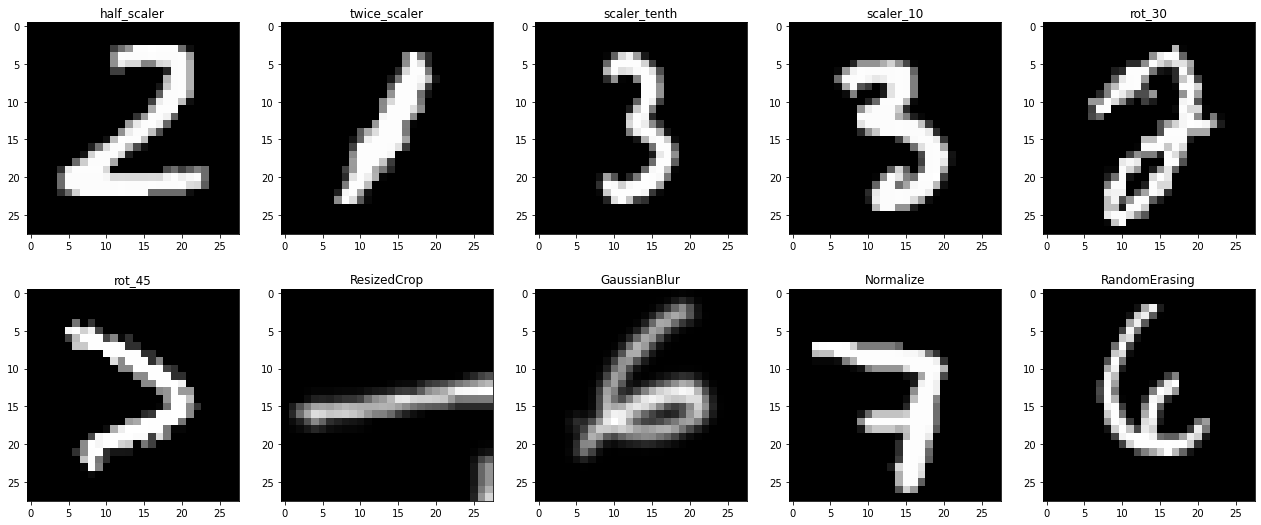

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(22, 9))

def plot_transfo(f, i, name):
    for data in test_dataloader:
        images, labels = data
        images = f(images)
        axs[i//5, i%5].imshow(images[0,0, :, :], cmap='gray')
        axs[i//5, i%5].set_title(name)
        break

for i, test in enumerate(list_test[1:]):
    name, f = test
    print(" ")
    print("Test :", name)
    plot_transfo(f, i, name)

plt.show()

## Test Modularity of the different Networks

In [ ]:
def compute_sum_up():
    ls = []
    print("test modularity...")
    for net in (all_models):
        ls.append((test_modularity(net)))

    df = pd.DataFrame(ls, index = [model.name for model in all_models])

    # Comparison between models
    df_diff_baseline = df.copy(deep=True)

    for i in range(2,len(df.index)):
        df_diff_baseline.iloc[i] = df.iloc[i] - df.iloc[1]

    df_diff_baseline["mean"] = df_diff_baseline.mean(axis=1)
    df_diff_baseline = df_diff_baseline.drop(df.index[:2])

    return df, df_diff_baseline

## Training and results

In [ ]:
epoch = 0
RES = []
ls_checkpoint_epoch = [1, 2, 5, 10, 20]
ls_check = [0]+ls_checkpoint_epoch
for EP in tqdm([ls_check[i]-ls_check[i-1] for i in range(1,len(ls_check))]):
    for model in tqdm(all_models):
        print('')
        print("Model name:", model.name)
        train(model, nb_epoch=EP)
    epoch += EP
    df, df_diff_baseline = compute_sum_up()
    RES.append((epoch,df, df_diff_baseline ))

résults epoch 1

In [ ]:
for res in RES :
    epoch,df, df_diff_baseline  = res
    print(" ")
    print("EPOCH : ", epoch)
    display(df)
    display(df_diff_baseline)

conclusion à la 20e époch:
L'attention transversale à éviter. Attention top down ne change pas la donne.

- le perceptron de merde sans aucune attention fait mieux que tout le monde même sur les tâches compliquées sur toutes les tâche. C'est la domination totale. Au moins comme ça c'est clair.
- faire un perceptron sans attention avec 3 briques permet de presque être au meilleur niveau. Mais on voit que rajouter des briques n'améliore pas les résultats si les briques ne communiquent pas entre elle. Etonnament, ça ne permet pas de faire un modèle type bagging.
- Rajouter de l'attention transversale fait grandement diminuer les performances : comme on le voit dans les modèles baseline, 3b4l8h, 3b4lTtd (ici on l'a mis que l'attention transversale, et les performances sont mauvaises)


Commentaire sur expérience à faire en plus :
- 12b2l marche assez bien pour un réseau à seuelement deux briques. Comparer sans attention transversale et td.
- 1b12l marche peu. Mais on sait maintenant que c'est à cause de l'attention trasversale qui ne sert à rien ici car il n'y a qu'une seule brique.
- faire une experience avec 4*4 réseaux pour chacune des tailles et attention.

In [ ]:
for model in (all_models):
    plot_losses(model)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')